[![logo](https://climate.copernicus.eu/sites/default/files/custom-uploads/branding/LogoLine_horizon_CAMS.png)](https://atmosphere.copernicus.eu)

# Policy tools

 **Run the tutorial via free cloud platforms**: [![binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/ecmwf-training/cams-act6/main?labpath=09-policy/policy_tools.ipynb)
[![kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-training/cams-act6/blob/main/09-policy/policy_tools.ipynb)
[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ecmwf-training/cams-act6/blob/main/09-policy/policy_tools.ipynb)

The policy tools provide two APIs to consume the policy data using a client software, such as this notebook, instead of by a person.

## APIs

### Air Control Toolbox (ACT)
https://policy.atmosphere.copernicus.eu/data/{yyyymm}/{model}/{mod}_{city}_{yyyymmdd}.json
https://policy.atmosphere.copernicus.eu/data/{yyyymm}/CHIMERE/{model}_{city}_{yyyymmdd}.json

### Source Allocation
https://policy.atmosphere.copernicus.eu/data/climato/{city}-{parameter}-{model}-{year}.json

## Questions
1. Which are the 10 cities where the dust share in PM10 is highest ?
2. On average between 2021 and 2023, which country contributed most to PM10 pollution in Prague ?
3. Which are the 10 cities where the maritime sector had the largest impact on ozone daily max between June and August 2024 ?

### Import libraries

In [1]:
import os
import sys
import json
import requests
import urllib
import urllib.request
import pandas as pd
import math
import datetime
from math import ceil, sqrt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')

### Question 1
Here we want to answer the question: which are the 10 cities where the dust share in PM10 is highest ? We could answer this question by using the [Policy Tools](https://policy.atmosphere.copernicus.eu/daily_source_attribution/chemical_species.php?model=CHIMERE) website and selecting "Chemical speciation" in the "Daily Source Attribution" menu. We can hereafter select the date, the city, and the model. For this question we will use the CHIMERE model. We can use the API to send a request for each city and process the data to answer our question. We start by reading the file that contains the name of the cities for which the policy webste provides the forecasts.

In [2]:
cities_file_url = 'https://raw.githubusercontent.com/ecmwf-training/cams-act6/main/09-policy/cities.txt'
r = requests.get(cities_file_url)
cities_file_path = f'cities.txt'
with open(cities_file_path, 'wb') as f:
        f.write(r.content)

In [3]:
with open('cities.txt', 'r', encoding="utf8") as file:
    cities = [line.strip() for line in file]

In [4]:
num_cities = len(cities)
num_cities

80

In [5]:
def act_chimere_url(day, city):
    city = urllib.parse.quote(city) # utf-8 encode for the url
    return 'https://policy.atmosphere.copernicus.eu/data/' + day[:6] + '/CHIMERE/ACT_' + city + '_' + day + '.json'

In [10]:
day = '20240915'
city = 'Malmö'

In [11]:
act_forecast_url = act_chimere_url(day, city)
act_forecast_url

'https://policy.atmosphere.copernicus.eu/data/202409/CHIMERE/ACT_Malm%C3%B6_20240915.json'

In [12]:
file_name = city + '_' + day + '.json'
file_name

'Malmö_20240915.json'

In [13]:
with urllib.request.urlopen(act_forecast_url) as url:
    json_data = json.load(url)
    #print(json_data)

We can store the json file

In [14]:
with open(file_name, 'w') as f:
    json.dump(json_data, f)

We parse the json file to extract the information we need to answer our question: we look for the DUST value of the total concentration of PM10 

In [18]:
def compute_dust_fraction(json_data, day):
    '''
    This function calculates the daily mean 
    dust fraction of PM10
    '''
    dust_fraction = 0.0
    for item in json_data.get(day):
        name = item['name'] 
        polluttant = item['poll']
        if (name == 'Total' and polluttant == 'DUST'):
            dust_fraction = sum(item['hOut'][:23]) / 24
    return dust_fraction  

In [20]:
dust_fraction = compute_dust_fraction(json_data, day)
print('Dust fraction in {:s} for {:s}: {:.2f}'.format(city, day, dust_fraction))

Dust fraction in Malmö for 20240915: 0.01


Now we put everything together to send a request for each city and extract the amount of dust within the total amount of PM10

In [25]:
def dust_pm10(cities, day):
    cities_dust_pm10 = []
    for city in cities:
        act_data_url = act_chimere_url(day, city)
        with urllib.request.urlopen(act_data_url) as url:
            json_data = json.load(url)
            dust_fraction = compute_dust_fraction(json_data, day)
            #print('City: {:s}, PM10 dust fraction: {:.2f}'.format(city, dust_fraction))
            cities_dust_pm10.append(round(dust_fraction, 2))
    return cities_dust_pm10

In [26]:
cities_dust_fraction_pm10 = dust_pm10(cities, '20240914')

In [27]:
cities_dust = zip(cities, cities_dust_fraction_pm10)

We sort the result and print the 10 cities with the highest share of dust in PM10

In [28]:
sorted(cities_dust, key=lambda x: x[1], reverse=True)[:10]

[('Helsinki', 2.23),
 ('Vilnius', 1.16),
 ('Riga', 0.91),
 ('Tallinn', 0.71),
 ('Nicosia', 0.09),
 ('Lisbon', 0.05),
 ('Seville', 0.05),
 ('Dublin', 0.04),
 ('Amsterdam', 0.02),
 ('Barcelona', 0.02)]

### Question 2
Here the question is: on average between 2021 and 2023, which country contributed most to PM10 pollution in Prague ? We could answer this question using the [policy tools](https://policy.atmosphere.copernicus.eu/daily_source_attribution/country_contribution.php?date=2024-09-10) by selecting "Country contribution" in the "Yearly Air Pollution Analysis" menu. Afterward we select the city of Prague and PM10 as the pollutant. 

In [31]:
def sa_url(city, year, polluttant):
    city = urllib.parse.quote(city) # utf-8 encode for the url
    return 'https://policy.atmosphere.copernicus.eu/data/climato/' + city + '-' + polluttant + '-TNO-' + year + '.json'

In [32]:
city = 'Prague'
year = '2024'
sa_data_url = sa_url(city, year, 'PM10')
sa_data_url

'https://policy.atmosphere.copernicus.eu/data/climato/Prague-PM10-TNO-2024.json'

In [36]:
file_name = city + '_TNO_' + year + '.json'
file_name

'Prague_TNO_2024.json'

In [41]:
 with urllib.request.urlopen(sa_data_url) as url:
    json_data = json.load(url)
    #print(data)

In [38]:
with open(file_name, 'w') as f:
    json.dump(json_data, f)

In [155]:
def compute_pm10_country_contribution(json_data):
    '''
    This function calculates the yearly country 
    contribution to the PM10 concentration in a 
    city
    '''
    countries = []
    for name in json_data['contributors']['name']:
        countries.append(name)
    
    country_contrib_list = []
    for country in json_data['contributors']['ts']['daily']:
        if (country in countries):
            country_contrib = sum(json_data['contributors']['ts']['daily'][country])
            country_contrib_list.append((country, country_contrib))
    return country_contrib_list

In [158]:
ranking = sorted(compute_pm10_country_contribution(json_data), key=lambda x: x[1], reverse=True)


[('CZE', 1707.79),
 ('Natural', 624.002),
 ('DEU', 451.829),
 ('Other contributions', 333.777),
 ('POL', 209.109),
 ('BIC', 137.389),
 ('FRA', 107.168),
 ('AUT', 71.651),
 ('SHP', 61.285),
 ('GBR', 45.595),
 ('HUN', 33.918)]

In [182]:
countries = []
contributions = []
for contrib in ranking:
    countries.append(contrib[0])
    contributions.append(contrib[1])

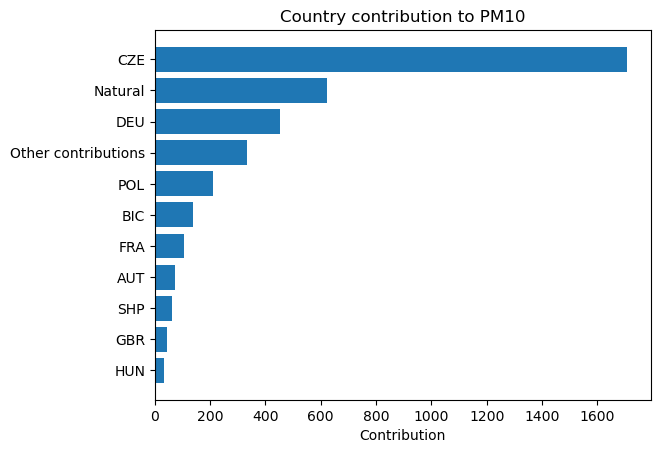

In [185]:
fig, ax = plt.subplots()
ax.barh(countries, contributions, align='center')
#ax.set_yticks(contributions, labels=countries)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Contribution')
ax.set_title('Country contribution to PM10')
plt.show()

### Question 3
Here the question is: which are the 10 cities where the maritime sector had the largest impact on ozone daily max between June and August 2024 ? The maritime sector is labeled as Ship or SHP. In order to answer this question we use the same API as for question 1. We select the "Sector apportionment" from the "Daily Source Attribution" menu, then $O_3$ as the polluttant, the date, and the city. The JSON file used to build the visualization on the web page can be downloaded from the link on righ hand side at the bottom. As we have done for question 1, we have to poll the website to get the data for all the cities and finally rank the first 10 for the largest impact on $O_3$ from the maritime (shipping) sector. 

In [29]:
city = 'Oslo'
day = '20240914'
act_forecast_url = act_chimere_url(day, city)
act_forecast_url

'https://policy.atmosphere.copernicus.eu/data/202409/CHIMERE/ACT_Oslo_20240914.json'

In [30]:
with urllib.request.urlopen(act_forecast_url) as url:
    json_data = json.load(url)

In [31]:
file_name = city + '_' + day + '.json'

In [32]:
with open(file_name, 'w') as f:
    json.dump(json_data, f)

In [33]:
def filter_sector_apportionment(json_data, day):
    impact_on_o3 = 0.0
    for item in json_data.get(day):
        name = item['name'] 
        polluttant = item['poll']
        if (name == 'Shipping' and polluttant == 'O3'):
            impact_on_o3 = max(item['hOut'][:23])
    return impact_on_o3  

In [37]:
maritime_impact_o3 = filter_sector_apportionment(json_data, day)
print('Impact of the maritime sector on ozone concentration in {:s}: {:.2f}'.format(city, maritime_impact_o3))

Impact of the maritime sector on ozone concentration in Oslo: 0.12


In [38]:
def impact_on_o3(cities, day):
    cities_maritime_impact_o3 = []
    for city in cities:
        act_data_url = act_chimere_url(day, city)
        with urllib.request.urlopen(act_data_url) as url:
            json_data = json.load(url)
            maritime_impact_o3 = filter_sector_apportionment(json_data, day)
            cities_maritime_impact_o3.append(maritime_impact_o3)
    return cities_maritime_impact_o3

In [42]:
cities_impact_maritime_o3 = impact_on_o3(cities, '20240914')

In [43]:
cities_impact = zip(cities, cities_impact_maritime_o3)

In [44]:
sorted(cities_impact, key=lambda x: x[1], reverse=True)[:10]

[('Lisbon', 14.493),
 ('Seville', 11.508),
 ('Valencia', 10.566),
 ('Nicosia', 8.993),
 ('Málaga', 8.471),
 ('Trójmiasto', 6.729),
 ('Valletta', 6.7),
 ('Malmö', 6.372),
 ('PalmaDeMallorca', 5.653),
 ('Copenhagen', 5.53)]

## References
* [Colette et al. - Air Control Toolbox (ACT_v1.0): a flexible surrogate model to explore mitigation scenarios in air quality forecasts](https://gmd.copernicus.org/articles/15/1441/2022/)